In [1]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import get_ensg_id, estimate_s, CCC

In [2]:
plt.rcParams['font.size'] = '12'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [3]:
rna = ad.read_loom('/home/mffang/data/counts/10x_K562/rna/counts_filtered/adata.loom',validate=False)
rna

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 11518 × 62754
    obs: 'barcode'
    var: 'target_name'
    layers: 'ambiguous', 'mature', 'nascent'

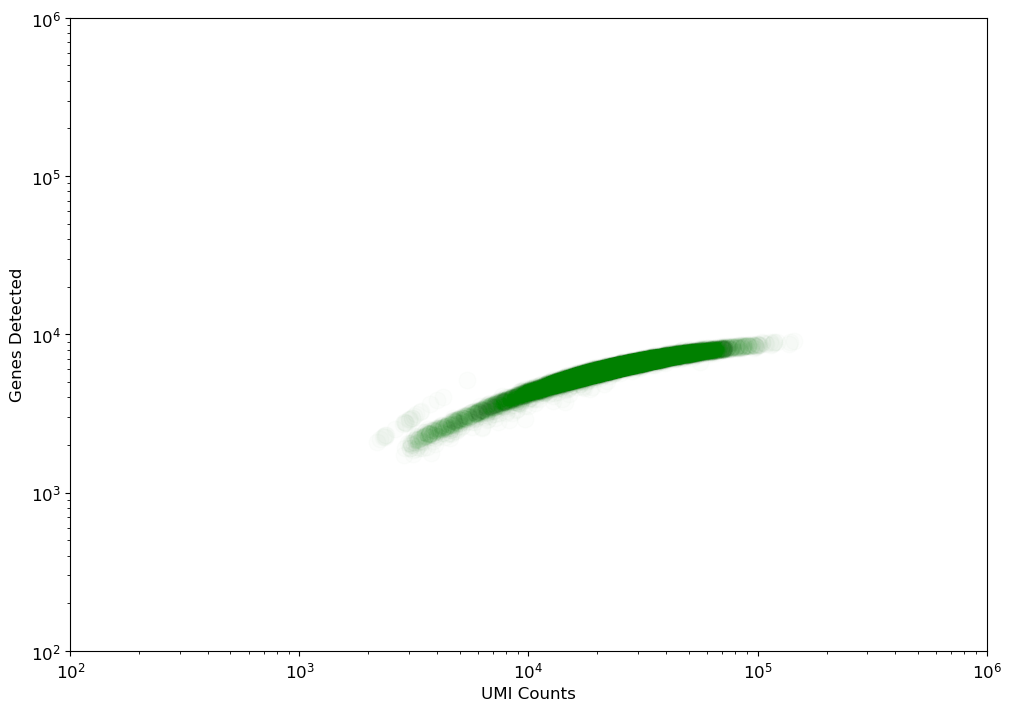

In [4]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1e2,1e6))
ax.set_ylim((1e2,1e6))

plt.show()

In [5]:
import statistics

statistics.median(mtx.sum(axis=1))

23246.5

In [6]:
rna.obs

,barcode
0,AAACAAGCAATAGAGA
1,AAACAAGCAATGAGCC
2,AAACAAGCACTAACGA
3,AAACAAGCACTCAAAG
4,AAACAAGCAGCACGTG
...,...
11513,TTTGGCGGTTGTCCAG
11514,TTTGTGAGTACGGGCA
11515,TTTGTGAGTACGTTCG
11516,TTTGTGAGTCCAGCTA


In [7]:
rna.var

,target_name
0,ENSG00000279928.2
1,ENSG00000228037.1
2,ENSG00000142611.17
3,ENSG00000284616.1
4,ENSG00000157911.11
...,...
62749,ENSG00000271254.7
62750,ENSG00000275987.1
62751,ENSG00000268674.2
62752,ENSG00000277475.1


## Calculate CV$^2$ of read depth

In [120]:
adata = rna.copy()
adata.layers['unspliced'] = adata.layers['nascent'] 
adata.layers['spliced'] = adata.layers['mature'] #+ adata.layers['ambiguous']

0.0006614563 0.09655499


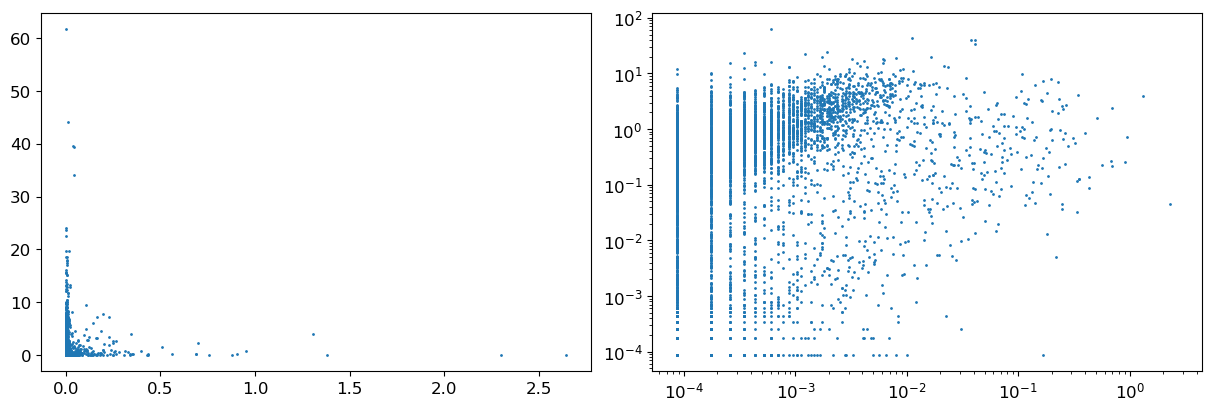

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

s estimated by total counts = 0.2849633449250348
1313 su= 0.2982226066858837
1140 ss= 0.2812532882898405
1131 s= 0.27946934635488496


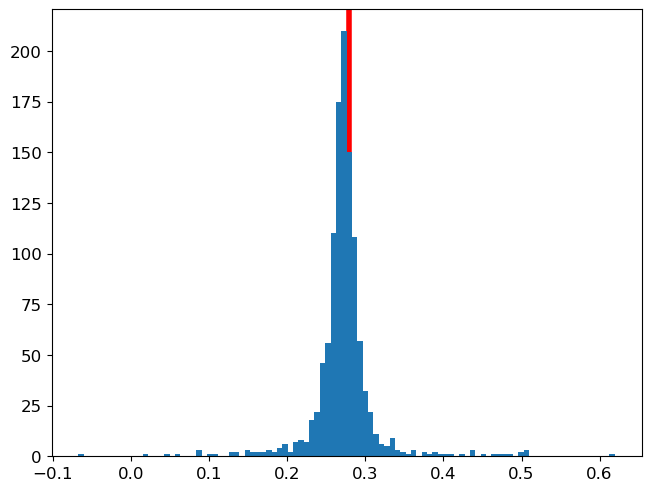

In [62]:
su, ss, sp = estimate_s(adata,min_mean=0.001)

Text(0.02, 0.5, 'CV$^2$')

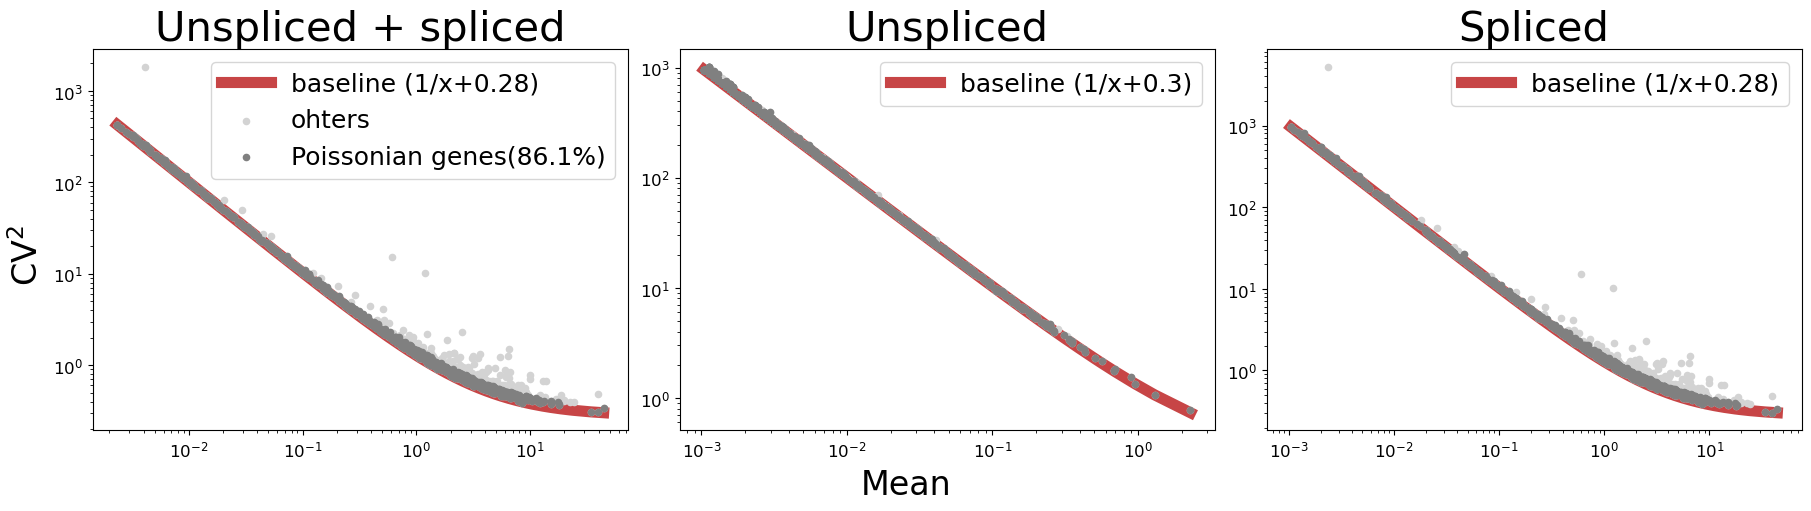

In [149]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.001) & (adata.layers["unspliced"].toarray().mean(0) > 0.001)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

0.2870722699096009 317
159 s= 0.2870722699096009
151 s= 0.2731949234757829
151 s= 0.2730650837755409
151 s= 0.2730650837755409
151 s= 0.2730650837755409
151 s= 0.2730650837755409
151 s= 0.2730650837755409
151 s= 0.2730650837755409
151 s= 0.2730650837755409
151 s= 0.2730650837755409


0.2500000000000011

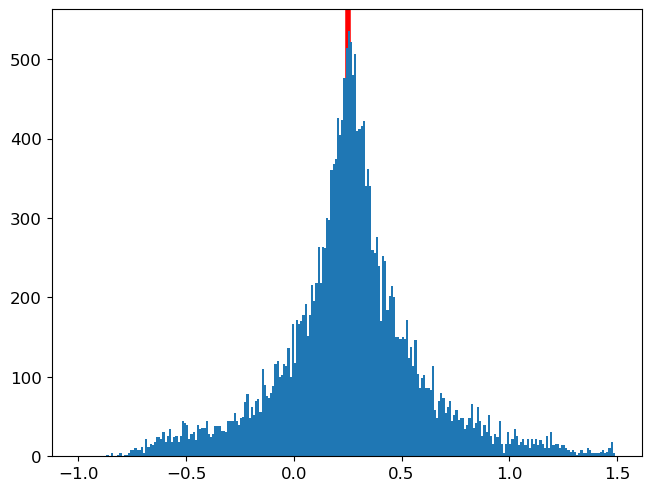

In [207]:
estimate_s(adata,layers=["unspliced","unspliced"])

0.28366758803810044 277
120 s= 0.28366758803810044
74 s= 0.25075982904098093
70 s= 0.24420165130146018
70 s= 0.24349716157434598
70 s= 0.24349716157434598
70 s= 0.24349716157434598
70 s= 0.24349716157434598
70 s= 0.24349716157434598
70 s= 0.24349716157434598
70 s= 0.24349716157434598


0.2500000000000011

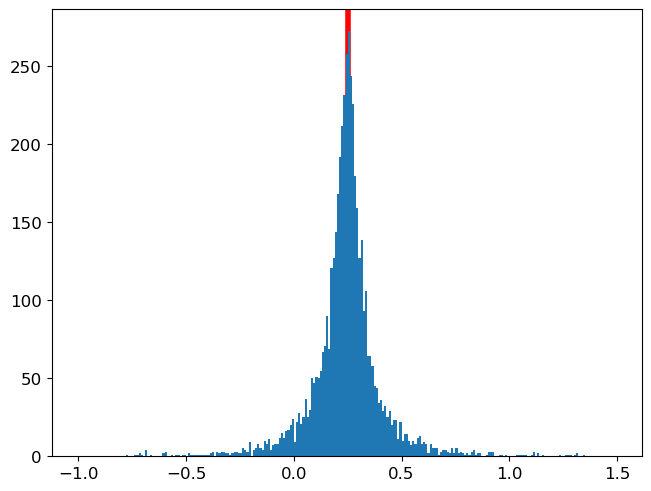

In [208]:
estimate_s(adata,layers=["unspliced","spliced"])

0.29797664044868816 5083
1897 s= 0.29797664044868816
923 s= 0.2666872412485057
717 s= 0.25922391211812107
667 s= 0.25718488601923034
658 s= 0.2565274186552216
653 s= 0.25645135126468244
653 s= 0.256436081108764
653 s= 0.256436081108764
653 s= 0.256436081108764
653 s= 0.256436081108764


0.2500000000000011

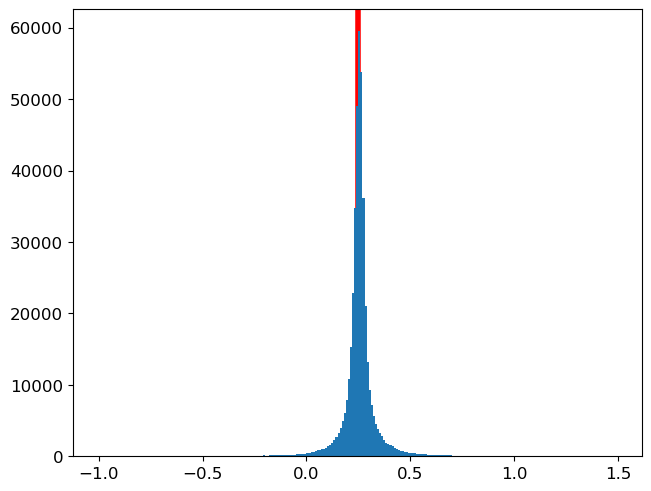

In [209]:
estimate_s(adata,layers=["spliced","spliced"])

In [151]:
X = np.concatenate((U,S),axis=1)
eta = np.cov(X,rowvar=False)/X.mean(0)[:,None]/X.mean(0)[None,:]
p = U.shape[1]
P = eta.shape[0]
s = (np.sum(eta)-np.sum(np.diag(eta)))/((P-1)*P)
print(eta.mean(),s)

0.36597037192695697 0.28336574146709625


0.2982226066858837

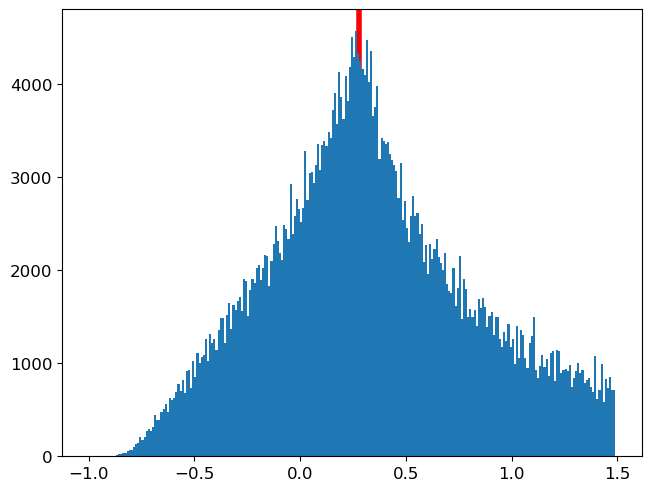

In [152]:
eta_ = eta[:p,:p]
plt.hist(eta_.flatten(),bins=np.arange(-1,1.5,0.01));
plt.axvline(x=sp,c='r',zorder=0)
(np.sum(eta_)-np.sum(np.diag(eta_)))/((p-1)*p)

0.2727151175394605

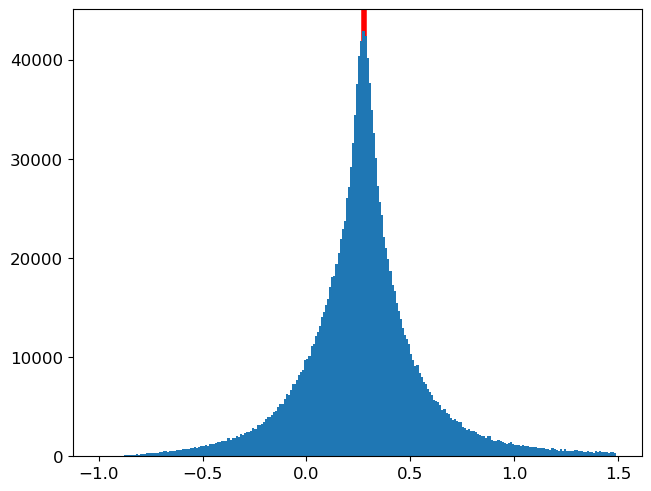

In [153]:
eta_ = eta[p:,:p]
plt.hist(eta_.flatten(),bins=np.arange(-1,1.5,0.01));
plt.axvline(x=sp,c='r',zorder=0)
(np.sum(eta_)-np.sum(np.diag(eta_)))/((p-1)*p)

0.2895882960296423

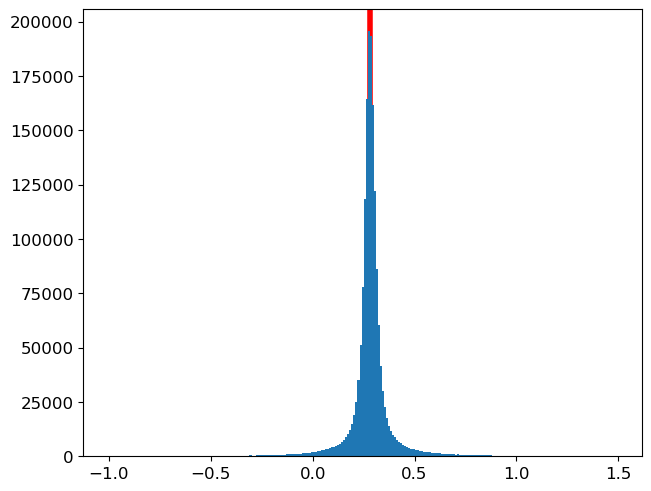

In [154]:
eta_ = eta[p:,p:]
plt.hist(eta_.flatten(),bins=np.arange(-1,1.5,0.01));
plt.axvline(x=sp,c='r',zorder=0)
(np.sum(eta_)-np.sum(np.diag(eta_)))/((p-1)*p)

In [155]:
rd = X[:,Pgene_mask].mean(1)/X[:,Pgene_mask].mean()
rd_ = X.mean(1)/X.mean()
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
ax.scatter(rd,rd_)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
plt.legend(loc=(1.01,0),fontsize=legend_font)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 2626 but corresponding boolean dimension is 1313

0.898840206185567


Text(0.5, 1.0, 'U+S+A')

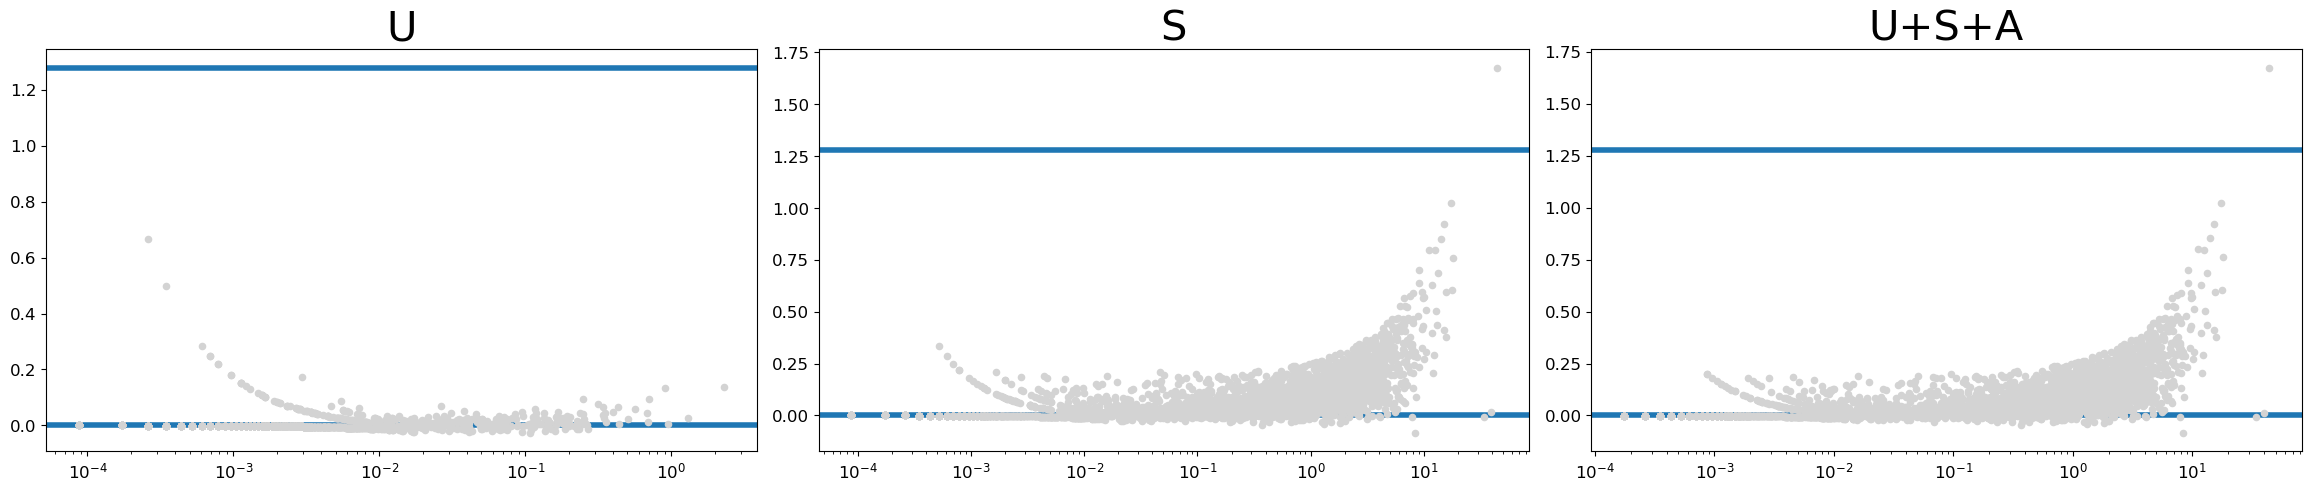

In [64]:
print(Pgene_mask.mean())
s=sp
def f(X):
    mean = np.mean(X,axis=0)
    var = np.var(X,axis=0)
    return var/mean-s*mean-1

fig, ax = plt.subplots(1,3,figsize=(23,4.8))
ax[0].scatter(U_mean[Pgene_mask], f(U[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[0].axhline(y=0,zorder=0)
ax[0].axhline(y=1+s,zorder=0)
ax[0].set_xscale('log')
ax[0].set_title('U',fontsize=title_font)

ax[1].scatter(S_mean[Pgene_mask], f(S[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[1].axhline(y=0,zorder=0)
ax[1].axhline(y=1+s,zorder=0)
ax[1].set_xscale('log')
ax[1].set_title('S',fontsize=title_font)

X_ = S + U 
ax[2].scatter(X_mean[Pgene_mask], f(X_[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[2].axhline(y=0,zorder=0)
ax[2].axhline(y=1+s,zorder=0)
ax[2].set_xscale('log')
ax[2].set_title('U+S+A',fontsize=title_font)

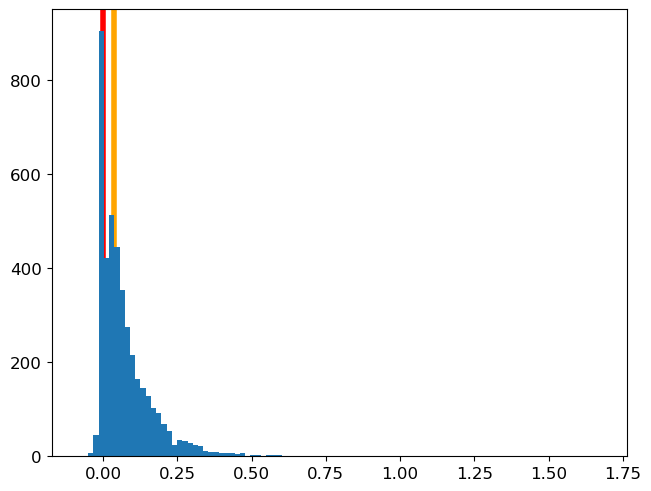

In [66]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.axvline(x=0.03*(1+s),c='orange',zorder=0)

# Check covariance relationships

In [212]:
mean_min = 0.1
idx = (adata.layers["spliced"].toarray().mean(0) > mean_min) & (adata.layers["unspliced"].toarray().mean(0) > mean_min) 

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
A = adata.layers["ambiguous"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(64,)

## Var(N_U)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


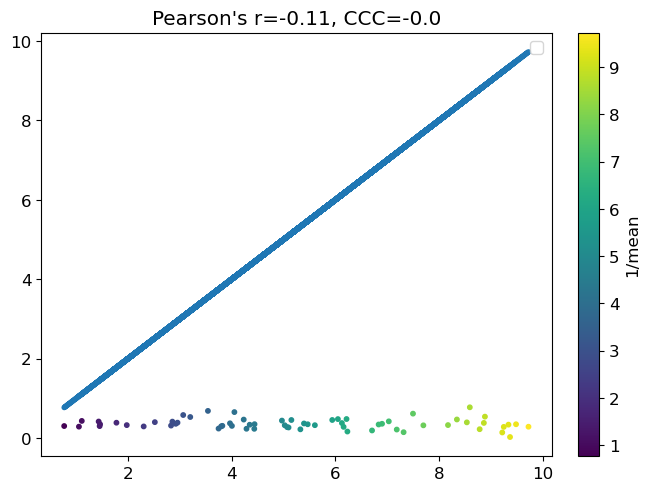

In [213]:
x = 1/U_mean
y = zeta_uu
plt.scatter(x,y,s=10,alpha=1,c=x)
plt.plot(x,x)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

Text(0.5, 1.0, '100.0% of cells >= 0')

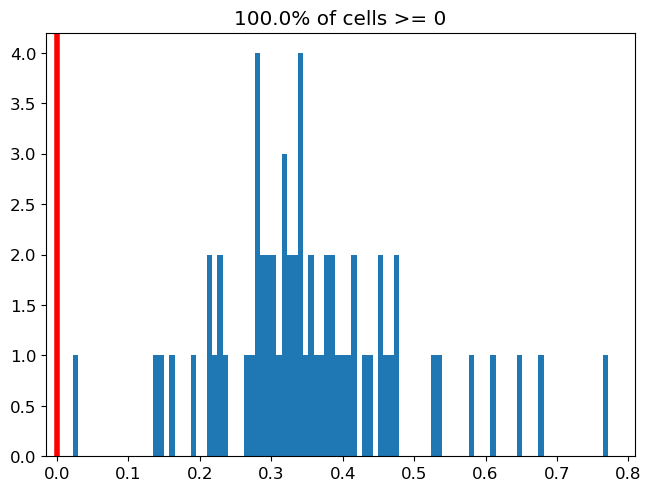

In [214]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_uu>=0).mean(),2))+'% of cells >= 0')

## Cov(N_u,N_s)
$$\zeta_{us}<\zeta_{uu}$$

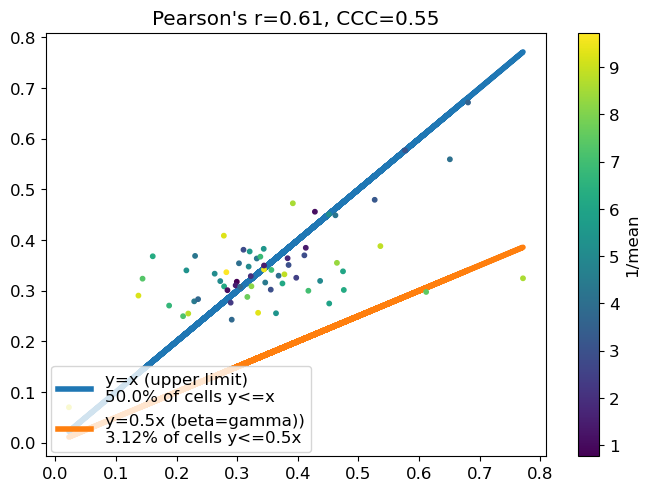

In [215]:
x=zeta_uu
y=zeta_us

plt.plot(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

## Var(N_s)

$$\zeta_{ss}=\zeta_{us}$$

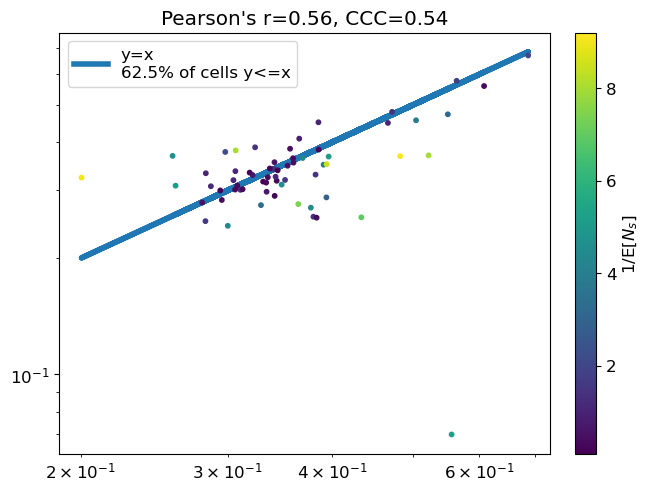

In [216]:
x=zeta_ss
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

# Check protein varaince

In [78]:
U = adata.layers["unspliced"].toarray()[:,gene_idx]
S = adata.layers["spliced"].toarray()[:,gene_idx]
P = np.array(protein.X.toarray()[cluster_idx],dtype=int)
P.shape

(340, 10)

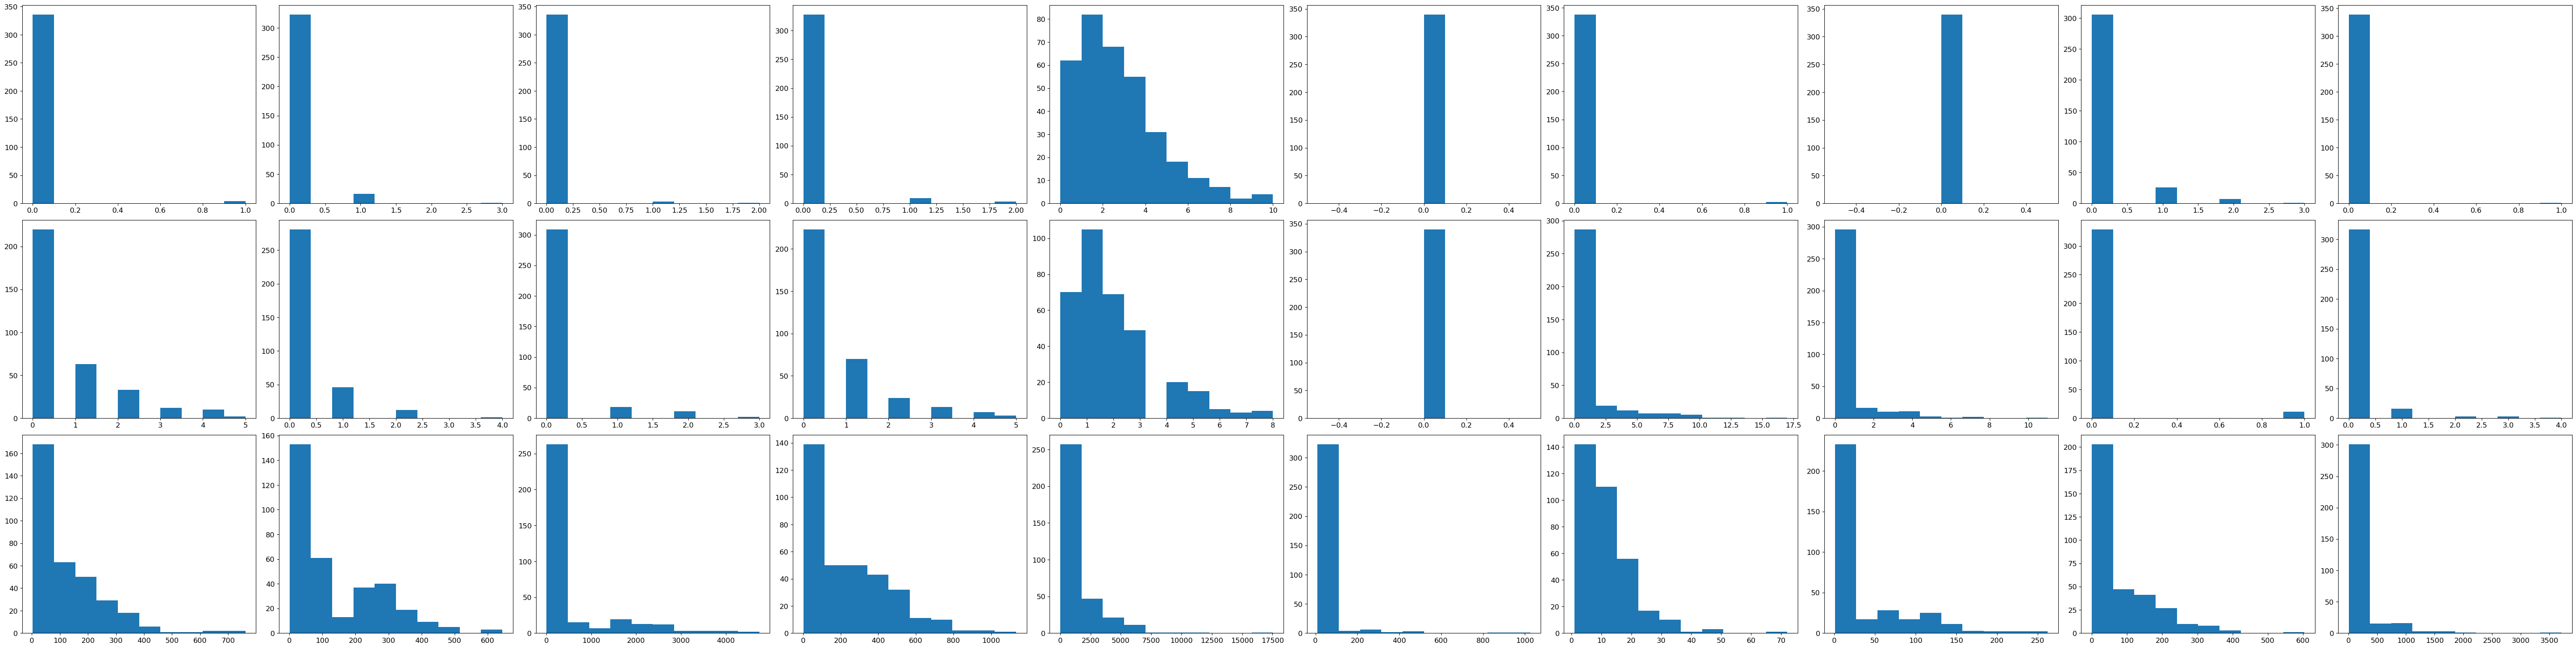

In [79]:
fig,ax = plt.subplots(3,10,figsize=(60,15))
for i in range(10):
    ax[0,i].hist(U[:,i])
    ax[1,i].hist(S[:,i])
    ax[2,i].hist(P[:,i])

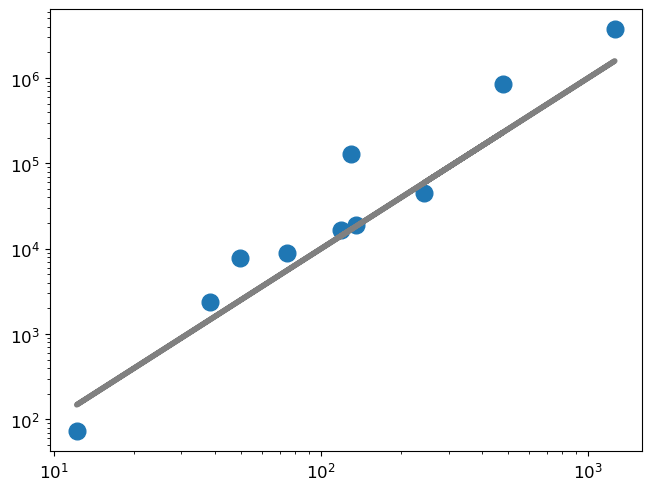

In [80]:
plt.scatter(P.mean(0),P.var(0))
plt.loglog(P.mean(0),P.mean(0)**2,'gray')

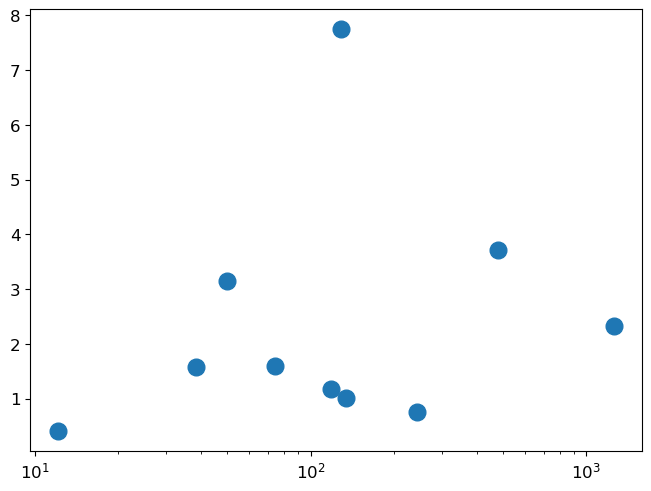

In [81]:
plt.scatter(P.mean(0),(P.var(0)-P.mean(0))/P.mean(0)**2)
plt.xscale('log')

In [82]:
iidx = (np.mean(U,axis=0)>0) &  (np.mean(S,axis=0)>0) &  (np.mean(P,axis=0)>0)
U = U[:,iidx]
S = S[:,iidx]
P = P[:,iidx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
P_mean = np.mean(P,axis=0)
P_var = np.var(P,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_pp = (P_var-P_mean)/P_mean**2
zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
cov_up = []
cov_sp = []
for i in range(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
    cov_up.append(np.cov(U[:,i],P[:,i])[0,1])
    cov_sp.append(np.cov(S[:,i],P[:,i])[0,1])
    
zeta_us = (np.array(cov_us)/U_mean/S_mean)
zeta_up = (np.array(cov_up)/U_mean/P_mean)
zeta_sp = (np.array(cov_sp)/S_mean/P_mean)
zeta_us

array([ 2.56568567, -0.27534754,  4.92753623,  1.8387414 ,  0.19829254,
        8.00042836,  2.60173249,  8.73999157])

## $Cov(N_u,N_p)$ 
$$ \gamma_p \zeta_{us} = (\gamma_p + \beta) \zeta_{up} $$  

In [83]:
zeta_up,zeta_us

(array([ 1.23711101,  1.01301436,  3.68821146,  0.97593109,  0.20403315,
         0.06886793,  0.98604154, 14.22379148]),
 array([ 2.56568567, -0.27534754,  4.92753623,  1.8387414 ,  0.19829254,
         8.00042836,  2.60173249,  8.73999157]))

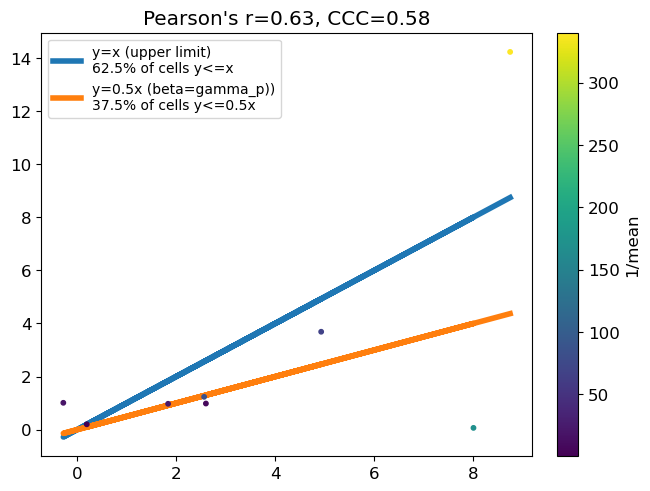

In [84]:
x=zeta_us
y=zeta_up

plt.plot(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma_p))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(fontsize=10)

## $Cov(N_s,N_p)$ 

$$\gamma (\zeta_{up}-\zeta_{sp}) + \gamma_p (\zeta_{ss}-\zeta_{sp}) = -\frac{\gamma_p}{\overline{X_s}} $$

In [85]:
zeta_up-zeta_sp,(zeta_up-zeta_sp)/(zeta_ss-zeta_sp)

(array([ 0.45357414,  0.65412781,  1.03778763,  0.33179173,  0.19208809,
        -0.60624778, -0.38086888,  5.6323643 ]),
 array([ 1.11074676,  0.74644718,  0.57250484,  0.50977384,  0.74721531,
        -0.12913643,  0.16091394, 14.06650829]))

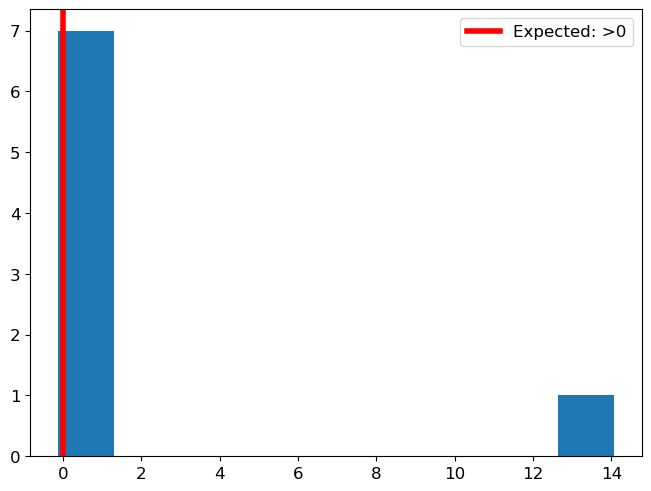

In [86]:
plt.hist((zeta_up-zeta_sp)/(zeta_ss-zeta_sp));
plt.axvline(x=0,c='r',label='Expected: >0')
plt.legend()

## $Var(N_p)$ 
$$ \zeta_{sp} = \zeta_{pp} $$  

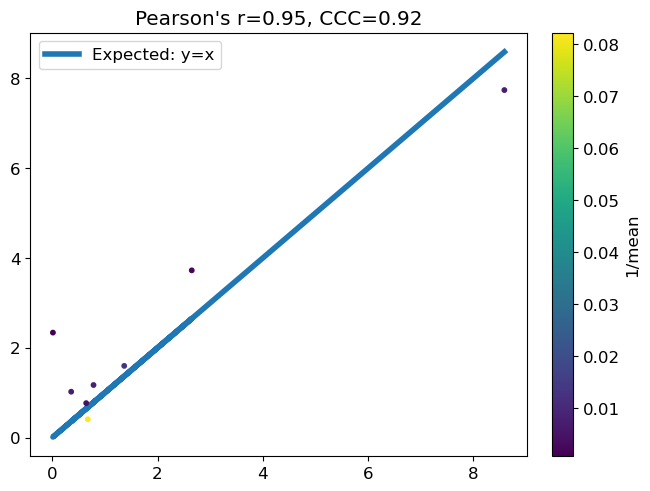

In [87]:
x=zeta_sp
y=zeta_pp

plt.plot(x,x,zorder=0,label='Expected: y=x')
plt.scatter(x,y,s=10,alpha=1,c=1/P_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()